In [463]:
import jax
jax.config.update("jax_enable_x64", True)

import os
import sys

sys.path.append('/Users/fllorente/Dropbox/con_Petar/PYTHON/gp_fusion')

import jax.numpy as jnp
from jax import grad, jit, vmap, value_and_grad, lax
from jax.scipy.linalg import cho_factor, cho_solve
import optax
from functools import partial

from modules.data_handling import load_data  # Same as using Dataset but X and Y have std dv = 1 column-wise
from modules.fusion_methods import compute_neg_log_like

import numpy as np
import matplotlib.pyplot as plt
import tqdm

In [464]:
# Example function with a dynamic slice
def example_function(x, start, length):
    # This will fail because `start` and `length` are dynamic
    slice_result = lax.dynamic_slice(x, (start,), (length,))
    # slice_result = x[start:length]
    return slice_result

# Create a sample array
x = jnp.array([1, 2, 3, 4, 5])

# Call the function with dynamic slicing
print(example_function(x, 1, 3))  # Output: [2, 3, 4]

# JIT compilation will fail with dynamic sizes
try:
    jit_example_function = jit(example_function, 
                               static_argnames=["start","length"],
                               )
    print(jit_example_function(x, 1, 3))
except Exception as e:
    print("Error during JIT compilation:", e)

[2 3 4]
[2 3 4]


## Joint learning without projections

In [504]:
def transform(raw_param, fun = "softplus"):               # raw_param lives in (-inf,inf)
    if fun == "exp":
        param = jnp.exp(raw_param)                      # exponential
    elif fun == "softplus":
        param = jnp.log(1 + jnp.exp(raw_param))         # softplus
    else:
        raise ValueError("Transform function not implemented.")
    return param        # param lives in (0,inf)  


def inv_transform(cons_param, fun = "invsoftplus"):          # cons_param lives in (0,inf)
    if fun == "log":
        param = jnp.log(cons_param)                          #  log   
    elif fun == "invsoftplus":
        param = jnp.log(jnp.exp(cons_param) - 1)             # inverse softplus
    else:
        raise ValueError("Inverse transform function not implemented.")
    return param       # param lives in (-inf,inf) 


# RBF Kernel function with length_scale as a vector
def rbf_kernel(x1, x2, length_scale, variance):
    sqdist = jnp.sum(((x1 - x2) / length_scale) ** 2)
    return variance * jnp.exp(-0.5 * sqdist)

# Efficient kernel matrix computation using vmap
def kernel_matrix(X1, X2, length_scale, variance, noise, include_noise = True):
    pairwise_sqdists = jnp.sum(
        ((X1[:, None, :] - X2[None, :, :]) / jnp.broadcast_to(length_scale, X1[:, None, :].shape)) ** 2, 
        axis=-1)
    K = variance * jnp.exp(-0.5 * pairwise_sqdists)
    if include_noise:
        K += noise * jnp.eye(X1.shape[0])
    return K

# Compute alpha and diagonal elements of the inverse of K using Cholesky
def compute_alpha_and_diag_inv_K(K_chol, y):
    alpha = cho_solve((K_chol, True), y)
    
    compute_diag = jax.vmap(lambda A, b, i: cho_solve((A, True), b)[i], in_axes=(None, 0, 0))
    diag_inv_K = compute_diag(K_chol, jnp.eye(K_chol.shape[0]), jnp.arange(K_chol.shape[0])) 
    
    return alpha, diag_inv_K

# LOO-CV objective function (negative log-score for minimization)
def loo_cv_objective(params, X, y, M,D, normalize_weights=False):
    
    length_scales_raw = lax.dynamic_slice(params, (0,), (M * D,)).reshape((M,D))
    variances_raw = lax.dynamic_slice(params, (M * D,), (M,))
    noises_raw = lax.dynamic_slice(params, (M * (D + 1),), (M,))
    weights_raw = lax.dynamic_slice(params, (M * (D + 2),), (M,))

    
    length_scales, variances, noises = transform(length_scales_raw), transform(variances_raw), transform(noises_raw)
    weights = transform(weights_raw)
    
    if normalize_weights:
        weights = weights / jnp.sum(weights)
    
    def gp_loops(length_scale, variance, noise):
        K = kernel_matrix(X, X, length_scale, variance, noise)
        K_chol = cho_factor(K, lower=True)[0]
        alpha, diag_inv_K = compute_alpha_and_diag_inv_K(K_chol, y)  # MAKE SURE y has one dimension => squeeze cabronazo!
        
        loo_means = y - alpha / diag_inv_K
        loo_vars = 1 / diag_inv_K
        
        return loo_means, loo_vars
    
    loo_means, loo_vars = vmap(gp_loops)(length_scales, variances, noises)
    
    # Fuse the means and variances using the product rule with weights
    weighted_vars_inv = weights[:, None] / loo_vars
    # print(weighted_vars_inv.shape)
    fused_vars = 1 / jnp.sum(weighted_vars_inv, axis=0)
    # print(fused_vars.shape)
    # print(loo_means.shape)
    fused_means = fused_vars * jnp.sum(weighted_vars_inv * loo_means, axis=0)

    # print(fused_means.shape, fused_vars.shape)
    
    # LOO predictive log-probability
    loo_cv_log_score = -0.5 * jnp.sum(jnp.log(fused_vars.squeeze()) + (y.squeeze() - fused_means.squeeze())**2 / fused_vars.squeeze())
    
    return -loo_cv_log_score  # Negative for minimization

# JIT compile the objective function for faster optimization
loo_cv_objective_jit = jit(loo_cv_objective, static_argnames=['M','D',"normalize_weights"])


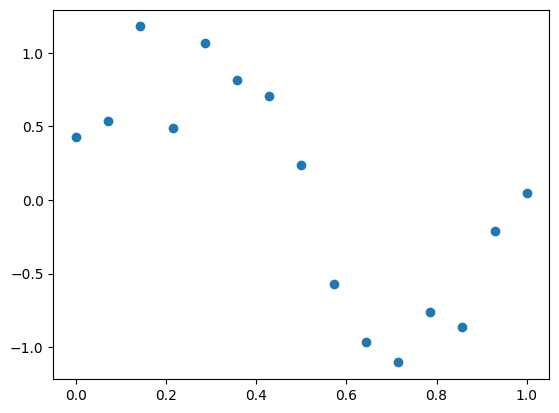

In [485]:
X_train = np.linspace(0,1,15).reshape(-1,1)
y_train = np.sin(2*np.pi*X_train).squeeze()
y_train = y_train + 0.3*np.random.randn(len(y_train))

X_test = jnp.linspace(0,1,300).reshape(-1,1)
y_test = jnp.sin(2*jnp.pi*X_test).squeeze()
y_test = y_test + 0.3*np.random.randn(len(y_test))

plt.scatter(X_train,y_train)

[2.04137604 3.8977985  4.1582978  4.15859286 4.16980767 4.17145696
 4.17148121 4.17158321 4.17148121 4.17145696 4.16980767 4.15859286
 4.1582978  3.8977985  2.04137604]
[2.04137604 3.8977985  4.1582978  4.15859286 4.16980767 4.17145696
 4.17148121 4.17158321 4.17148121 4.17145696 4.16980767 4.15859286
 4.1582978  3.8977985  2.04137604]


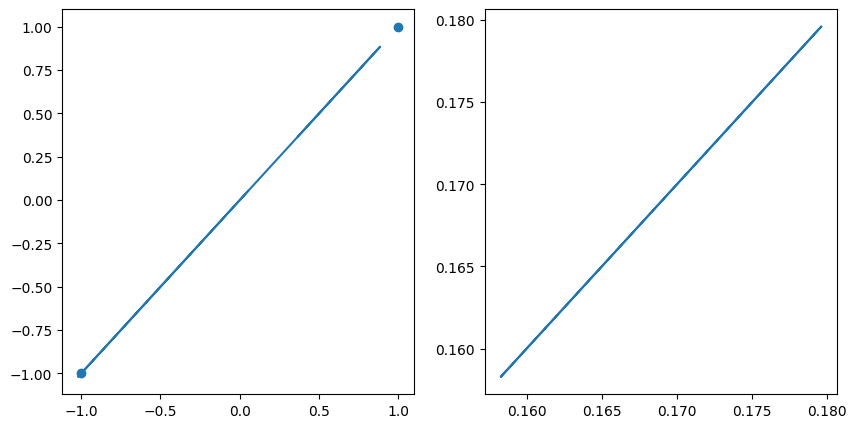

In [498]:
# Testing that the computation of the alpha and diagonal elements of K_inv are correct:
K = kernel_matrix(X_train,X_train,0.1,1,0.1)
print(jnp.diag(jax.scipy.linalg.inv(K)))

K_cho_factor,_ = cho_factor(K,True)   # True for lower triangular Cholesky decomposition
alpha, aqui = compute_alpha_and_diag_inv_K(K_cho_factor,y_train)
print(aqui)

# If alpha is correct, we should get the same posterior mean
def gp_predict(X_train, X_test, length_scale, variance, noise):
    K = kernel_matrix(X_train, X_train, length_scale, variance, noise)
    K_s = kernel_matrix(X_test, X_train, length_scale, variance, noise, include_noise=False)
    K_ss = kernel_matrix(X_test, X_test, length_scale, variance, noise)
    
    K_chol = cho_factor(K, lower=True)[0]
    
    alpha = cho_solve((K_chol, True), y_train)
    v = cho_solve((K_chol, True), K_s.T)
    
    mu_s = K_s @ alpha
    cov_s = K_ss - K_s @ v
    
    return mu_s, jnp.diag(cov_s)

mu_post, var_post = gp_predict(X_train,X_test,0.1, 1, 0.1)
# plt.plot(X_test,mu_post,lw = 3)
# plt.fill_between(X_test.squeeze(), mu_post + 2*jnp.sqrt(var_post),
#                  mu_post - 2*jnp.sqrt(var_post), alpha = 0.3)

my_mu = kernel_matrix(X_test,X_train,0.1,1,0.1,include_noise=False) @ alpha
my_var = jnp.diag( kernel_matrix(X_test,X_test,0.1, 1, 0.1) - \
                           kernel_matrix(X_test,X_train,0.1,1,0.1,include_noise=False) @ \
                            cho_solve((K_cho_factor,True), 
                                      kernel_matrix(X_train,X_test,0.1,1,0.1,include_noise=False))
                                      )

fig,ax = plt.subplots(figsize = (10,5),ncols=2,nrows=1)
ax[0].plot(mu_post,my_mu)
ax[0].scatter((-1,1),(-1,1))
ax[1].plot(var_post,my_var)
# ax[1].scatter((-0.1,0.1),(-0.1,0.1))

# plt.plot(X_test,my_mu)
# plt.fill_between(X_test.squeeze(), my_mu + 2*jnp.sqrt(my_var),
#                  my_mu - 2*jnp.sqrt(my_var), alpha = 0.1)

In [471]:
M = 3  # Number of GPs
D = X_train.shape[1]


# Initial parameters in natura scale (namely, they are constrained to be positive)
init_params = jnp.concatenate(
(
    # 0.1*jnp.ones((D,)),   # lengthscales of the first expert
    # 0.5*jnp.ones((D,)),   # lengthscales of the second expert
    0.5 - 0.5*jax.random.uniform(jax.random.PRNGKey(42), (M*D,)) ,
    1*jnp.ones((M,)),   # variances of the two experts
    0.01*jnp.ones((M,)),  # noises of the two experts
    jnp.ones((M,))        # weights
 )
)

# Inverse transform = inverse softplut
init_params = inv_transform(init_params)  

# Define the optimizer
optimizer = optax.adam(learning_rate=0.01)
opt_state = optimizer.init(init_params)

# Define the update step
@partial(jax.jit, static_argnames=['M', 'D', 'normalize_weights'])
def update(params, opt_state, X, y, M, D,normalize_weights):
    loss, grads = value_and_grad(loo_cv_objective_jit)(params, X, y, M, D,normalize_weights)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return loss, params, opt_state

# Training loop
params = init_params
num_steps = 200
normalize_weights = True  # Set this flag to True if weights should sum to 1
for step in range(num_steps):
    loss, params, opt_state = update(params, opt_state, X_train, y_train, M, D,normalize_weights)
    if step % 100 == 0 or step == num_steps-1:
        print(f"Step {step}, Loss: {loss}")

# Get the optimized parameters
# optimized_params = jnp.exp(params)  # Transform function = exponential
# optimized_params = jnp.log(1 + jnp.exp(params))  # Transform function = softplus
optimized_params = transform(params)

length_scales = optimized_params[:M * X_train.shape[1]].reshape((M, X_train.shape[1]))
variances = optimized_params[M * X_train.shape[1]:M * (X_train.shape[1] + 1)]
noises = optimized_params[M * (X_train.shape[1] + 1):M * (X_train.shape[1] + 2)]
weights = optimized_params[-M:]  # Get the weights as they are (log transformation has already been applied)
if normalize_weights:
    weights = weights / jnp.sum(weights)

print("Optimized Length Scales:", length_scales)
print("Optimized Variances:", variances)
print("Optimized Noises:", noises)
print("Optimized Weights:", weights)

Step 0, Loss: 1.0026941113346663
Step 100, Loss: -0.892211374000228
Step 199, Loss: -1.6567970456021053
Optimized Length Scales: [[0.45817712]
 [0.04652367]
 [0.04589485]]
Optimized Variances: [1.45134565 0.5405079  0.54047033]
Optimized Noises: [0.00064372 0.00455322 0.00455295]
Optimized Weights: [0.07915235 0.46037968 0.46046797]


In [316]:
length_scales.shape[0], variances.shape[0], noises.shape[0]

(3, 3, 3)

In [317]:
# Function to make predictions with the optimized GPs
def predict_fused_gp(X_train, y_train, X_test, length_scales, variances, noises, weights):
    def gp_predict(length_scale, variance, noise):
        K = kernel_matrix(X_train, X_train, length_scale, variance, noise)
        K_s = kernel_matrix(X_test, X_train, length_scale, variance, noise, include_noise=False)
        K_ss = kernel_matrix(X_test, X_test, length_scale, variance, noise)
        
        K_chol = cho_factor(K, lower=True)[0]
        
        alpha = cho_solve((K_chol, True), y_train)
        v = cho_solve((K_chol, True), K_s.T)
        
        mu_s = K_s @ alpha
        cov_s = K_ss - K_s @ v
        
        return mu_s, jnp.diag(cov_s)
    
    mus, covs = vmap(gp_predict)(length_scales, variances, noises) 

    print(mus.shape, covs.shape)

    # if normalize_weights:  # I forgot this here.... pero no hacia falta....
    #     weights = weights / jnp.sum(weights)
    
    weighted_vars_inv = weights[:, None] / covs
    fused_vars = 1 / jnp.sum(weighted_vars_inv, axis=0)
    fused_means = fused_vars * jnp.sum(weighted_vars_inv * mus, axis=0)
    
    return fused_means, fused_vars, mus, covs


# Make predictions
mu_tst, var_tst, mus, covs = predict_fused_gp(X_train, y_train, X_test, length_scales, variances, noises, weights)
mu_tr, var_tr, _ , _ = predict_fused_gp(X_train, y_train, X_train, length_scales, variances, noises, weights)


(3, 300) (3, 300)
(3, 25) (3, 25)


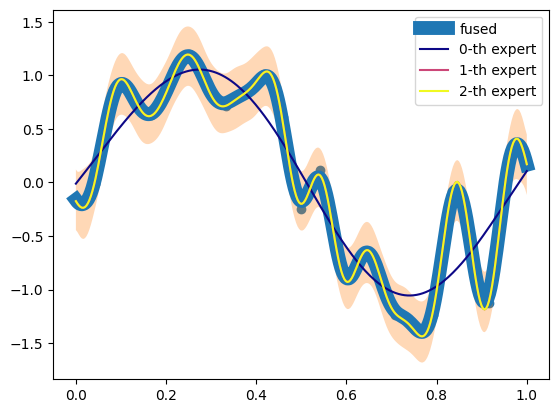

In [318]:
import matplotlib as mpl
cmap = mpl.colormaps['plasma']
colors = cmap(np.linspace(0, 1,M))

plt.scatter(X_train, y_train)
plt.plot(X_test,mu_tst, label = "fused", lw=10)
plt.fill_between(X_test.squeeze(),mu_tst + 2*jnp.sqrt(var_tst),
                 mu_tst - 2*jnp.sqrt(var_tst), alpha=0.3)
for m in range(M):
    plt.plot(X_test, mus[m,:], label = f"{m}-th expert", color = colors[m])

plt.legend() ;

In [319]:
print("NLPD Train: ", compute_neg_log_like(mus=mu_tr,stds=jnp.sqrt(var_tr),y_test=y_train))
print("NLPD Test: ",  compute_neg_log_like(mus=mu_tst,stds=jnp.sqrt(var_tst),y_test=y_test))

print("RMSE Train: ", jnp.sqrt( jnp.mean( (mu_tr.squeeze() - y_train.squeeze())**2 ) ))
print("RMSE Test: ", jnp.sqrt( jnp.mean( (mu_tst.squeeze() - y_test.squeeze())**2 ) ))

NLPD Train:  [-1.00694228]
NLPD Test:  [2.88472895]
RMSE Train:  0.04346605470811169
RMSE Test:  0.397776970357993


In [320]:
transform(init_params[:M * D].reshape(M,D)), transform(init_params[M * D : M * (D + 1)].reshape((M,)))

(Array([[0.13509055],
        [0.06540309],
        [0.06384987]], dtype=float64),
 Array([1., 1., 1.], dtype=float64))

In [321]:
# Make predictions
mu_tst, var_tst,mus,covs = predict_fused_gp(X_train, y_train, X_test, 
                             transform(init_params[:M * D].reshape(M,D)), 
                             transform(init_params[M * D : M * (D + 1)].reshape((M,))), 
                             transform(init_params[M * (D + 1):M * (D + 2)].reshape((M,))), 
                             transform(init_params[M * (D + 2):].reshape((M,))),
                             )
mu_tr, var_tr,_,_ = predict_fused_gp(X_train, y_train, X_train, jnp.exp(init_params[:M * D].reshape(M,D)), 
                             transform(init_params[M * D : M * (D + 1)].reshape((M,))), 
                             transform(init_params[M * (D + 1):M * (D + 2)].reshape((M,))), 
                             transform(init_params[M * (D + 2):].reshape((M,))),
                             )

print("NLPD Train: ", compute_neg_log_like(mus=mu_tr,stds=jnp.sqrt(var_tr),y_test=y_train))
print("NLPD Test: ",  compute_neg_log_like(mus=mu_tst,stds=jnp.sqrt(var_tst),y_test=y_test))

print("RMSE Train: ", jnp.sqrt( jnp.mean( (mu_tr.squeeze() - y_train.squeeze())**2 ) ))
print("RMSE Test: ", jnp.sqrt( jnp.mean( (mu_tst.squeeze() - y_test.squeeze())**2 ) ))

(3, 300) (3, 300)
(3, 25) (3, 25)
NLPD Train:  [1.26413315]
NLPD Test:  [9.36923912]
RMSE Train:  0.17609229857700476
RMSE Test:  0.3418717739842596


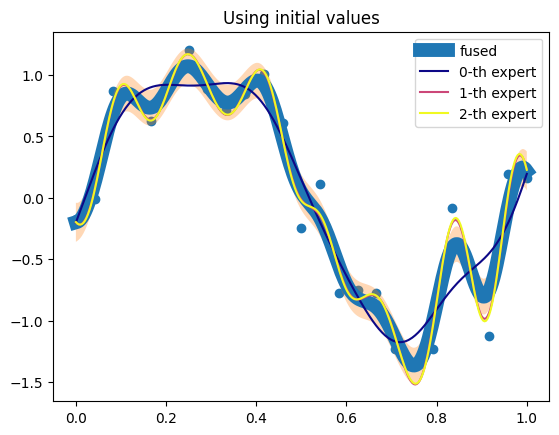

In [322]:
plt.scatter(X_train, y_train)
plt.plot(X_test,mu_tst, label = "fused", lw = 10)
plt.fill_between(X_test.squeeze(),mu_tst + 2*jnp.sqrt(var_tst),
                 mu_tst - 2*jnp.sqrt(var_tst), alpha=0.3)
for m in range(M):
    plt.plot(X_test, mus[m,:], label = f"{m}-th expert", color = colors[m])

plt.legend()  
plt.title("Using initial values");

In [501]:
import gpytorch
from modules.model_training import GPModel, to_torch

likelihood = gpytorch.likelihoods.GaussianLikelihood(
        noise_constraint=gpytorch.constraints.GreaterThan(1e-4)
        )

model = GPModel(to_torch(X_train), to_torch(y_train).squeeze(-1), 
                likelihood,
                kernel = None,
                mean = gpytorch.means.ZeroMean(),
                 )
print(
model.covar_module.base_kernel.lengthscale,
model.covar_module.outputscale,
model.mean_module,
model.likelihood.noise_covar.noise,
)

for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

tensor([[0.6931]], grad_fn=<SoftplusBackward0>) tensor(0.6931, grad_fn=<SoftplusBackward0>) ZeroMean() tensor([0.6932], grad_fn=<AddBackward0>)
Parameter name: likelihood.noise_covar.raw_noise           value = 0.0
Parameter name: covar_module.raw_outputscale               value = 0.0
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 0.0


In [503]:
transform(likelihood.noise_covar.raw_noise.detach().numpy())

Array([0.6931472], dtype=float32)

## UCI dataset

In [417]:
from uci_datasets import Dataset
dataset_names = ["autos", 'housing','stock','sml',
                 'elevators','breastcancer','forest','gas',
                 ]


dataset_name = dataset_names[1]
full_dataset = Dataset(dataset_name)
N,DIM = full_dataset.x.shape

from sklearn.model_selection import train_test_split

# X = full_dataset.x / np.std(full_dataset.x, axis=0)[None, :]
# y = full_dataset.y / np.std(full_dataset.y, axis=0)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
# y_train = y_train.squeeze()
# y_test = y_test.squeeze()
# load_data uses the normalized dataset, i.e., full_dataset.x and full_dataset.y have unit variance
split = 0
X_train,y_train,X_test,y_test,_ = load_data(dataset_name,split)

housing dataset, N=506, d=13


In [418]:
np.std(X_train, axis=0)

array([0.92630203, 1.0072248 , 0.9873066 , 1.00669779, 0.98479635,
       1.00126162, 1.00985089, 0.98640581, 1.00239999, 0.99995377,
       0.98726737, 0.96230384, 0.9794359 ])

In [419]:
%%script true
X_train = X_train[::3]
y_train = y_train[::3].squeeze()
y_test = y_test.squeeze()

In [420]:
X_train.shape, y_train.shape

((456, 13), (456,))

In [433]:
M = 2  # Number of GPs
D = X_train.shape[1]


# Initial parameters: length_scale, variance, noise, weights (they have to be positive!)
init_params = jnp.concatenate(
(
    # 0.1*jnp.ones((D,)), 0.5*jnp.ones((D,)), 1*jnp.ones((D,)),
    # 0.5 - 0.5*jax.random.uniform(jax.random.PRNGKey(42), (M*D,)) ,
    0.1*jnp.ones((M*D,)),
    jnp.ones((M,)),
    0.2*jnp.ones((M,)),
    jnp.ones((M,))
    )
)

init_params = inv_transform(init_params)

# Define the optimizer
optimizer = optax.adam(learning_rate=0.1)
opt_state = optimizer.init(init_params)

# Define the update step
@partial(jax.jit, static_argnames=['M', 'D', 'normalize_weights'])
def update(params, opt_state, X, y, M, D,normalize_weights):
    loss, grads = value_and_grad(loo_cv_objective_jit)(params, X, y, M, D,normalize_weights)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return loss, params, opt_state

# Training loop
params = init_params
num_steps = 100
normalize_weights = True  # Set this flag to True if weights should sum to 1
losses = []
for step in tqdm.tqdm(range(num_steps)):
    loss, params, opt_state = update(params, opt_state, X_train, y_train, M, D,normalize_weights)
    losses.append(loss)
    if step % 100 == 0 or step == num_steps-1:
        print(f"Step {step}, Loss: {loss}")

# Get the optimized parameters
optimized_params = transform(params)

length_scales = optimized_params[:M * D].reshape((M, D))
variances = optimized_params[M * D:M * (D + 1)]
noises = optimized_params[M * (D + 1):M * (D + 2)]
weights = optimized_params[-M:]  # Get the weights as they are (log transformation has already been applied)
if normalize_weights:
    weights = weights / jnp.sum(weights)

print("Optimized Length Scales:", length_scales)
print("Optimized Variances:", variances)
print("Optimized Noises:", noises)
print("Optimized Weights:", weights)

  1%|          | 1/100 [00:01<03:16,  1.98s/it]

Step 0, Loss: 234.1910863700006


100%|██████████| 100/100 [00:25<00:00,  3.88it/s]

Step 99, Loss: -374.06872570737596
Optimized Length Scales: [[3.43434855 4.77465814 4.23042901 0.1        0.95203179 2.91919884
  2.83342696 0.83343712 1.95228718 0.66036642 4.05125349 2.01302312
  1.12583726]
 [3.43434855 4.77465814 4.23042901 0.1        0.95203179 2.91919884
  2.83342696 0.83343712 1.95228718 0.66036642 4.05125349 2.01302312
  1.12583726]]
Optimized Variances: [0.78821616 0.78821616]
Optimized Noises: [0.02877524 0.02877524]
Optimized Weights: [0.5 0.5]


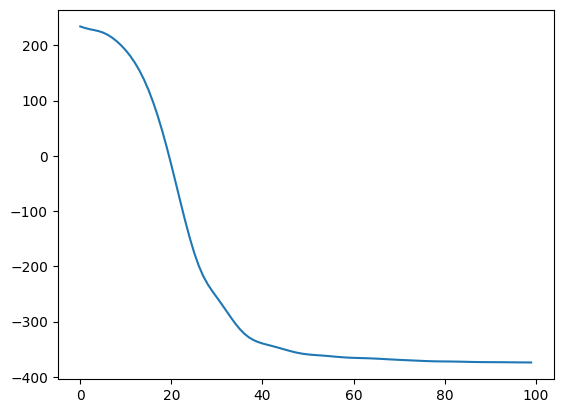

In [434]:
plt.plot(losses)

In [435]:
# Make predictions
mu_tst, var_tst,_,_ = predict_fused_gp(X_train, y_train, X_test, length_scales, variances, noises, weights)
mu_tr, var_tr,_,_ = predict_fused_gp(X_train, y_train, X_train, length_scales, variances, noises, weights)

print("NLPD Train: ", compute_neg_log_like(mus=mu_tr,stds=jnp.sqrt(var_tr),y_test=y_train))
print("NLPD Test: ",  compute_neg_log_like(mus=mu_tst,stds=jnp.sqrt(var_tst),y_test=y_test))

print("RMSE Train: ", jnp.sqrt( jnp.mean( (mu_tr.squeeze() - y_train.squeeze())**2 ) ))
print("RMSE Test: ", jnp.sqrt( jnp.mean( (mu_tst.squeeze() - y_test.squeeze())**2 ) ))


print("--------  Below, using initial parameter values -------")
# Make predictions
mu_tst, var_tst,_,_ = predict_fused_gp(X_train, y_train, X_test, 
                             transform(init_params[:M * D].reshape(M,D)), 
                             transform(init_params[M * D : M * (D + 1)].reshape((M,))), 
                             transform(init_params[M * (D + 1):M * (D + 2)].reshape((M,))), 
                             transform(init_params[M * (D + 2):].reshape((M,))),
                             )
mu_tr, var_tr,_,_ = predict_fused_gp(X_train, y_train, X_train, jnp.exp(init_params[:M * D].reshape(M,D)), 
                             transform(init_params[M * D : M * (D + 1)].reshape((M,))), 
                             transform(init_params[M * (D + 1):M * (D + 2)].reshape((M,))), 
                             transform(init_params[M * (D + 2):].reshape((M,))),
                             )

print("NLPD Train: ", compute_neg_log_like(mus=mu_tr,stds=jnp.sqrt(var_tr),y_test=y_train))
print("NLPD Test: ",  compute_neg_log_like(mus=mu_tst,stds=jnp.sqrt(var_tst),y_test=y_test))
print("RMSE Train: ", jnp.sqrt( jnp.mean( (mu_tr.squeeze() - y_train.squeeze())**2 ) ))
print("RMSE Test: ", jnp.sqrt( jnp.mean( (mu_tst.squeeze() - y_test.squeeze())**2 ) ))

(2, 50) (2, 50)
(2, 456) (2, 456)
NLPD Train:  [-0.48878633]
NLPD Test:  [0.08352257]
RMSE Train:  0.11388113514564684
RMSE Test:  0.3340788383102606
--------  Below, using initial parameter values -------
(2, 50) (2, 50)
(2, 456) (2, 456)
NLPD Train:  [0.14751433]
NLPD Test:  [1.32756268]
RMSE Train:  0.16795845110822266
RMSE Test:  0.8924902681255349


## With projections

In [447]:
# LOO-CV objective function (negative log-score for minimization)
def loo_cv_objective(params, X, y, M,proj_dim, normalize_weights=False, proj_seed = 42):

    N,DIM = X.shape

    length_scales_raw = lax.dynamic_slice(params, (0,), (M * proj_dim,)).reshape((M,proj_dim))
    variances_raw = lax.dynamic_slice(params, (M * proj_dim,), (M,))
    noises_raw = lax.dynamic_slice(params, (M * (proj_dim + 1),), (M,))
    weights_raw = lax.dynamic_slice(params, (M * (proj_dim + 2),), (M,))
  
    length_scales, variances, noises = transform(length_scales_raw), transform(variances_raw), transform(noises_raw)


    weights = transform(weights_raw)


    X_reps = jnp.tile(jnp.expand_dims(X,0), (M,1,1))
    P_projs = jax.random.normal(jax.random.PRNGKey(proj_seed), (M,DIM, proj_dim))/jnp.sqrt(proj_dim)   
    X_projs = jax.vmap(lambda A,B: (A @ B).squeeze(), in_axes=(0, 0))(X_reps, P_projs)
    assert X_projs.shape == (M,N,proj_dim)

    
    if normalize_weights:
        weights = weights / jnp.sum(weights)
    
    def gp_loops(X,length_scale, variance, noise):
        K = kernel_matrix(X, X, length_scale, variance, noise)
        K_chol = cho_factor(K, lower=True)[0]
        alpha, diag_inv_K = compute_alpha_and_diag_inv_K(K_chol, y)
        
        loo_means = y - alpha / diag_inv_K
        loo_vars = 1 / diag_inv_K
        
        return loo_means, loo_vars
    
    loo_means, loo_vars = vmap(gp_loops)(X_projs,length_scales, variances, noises)
    
    # Fuse the means and variances using the product rule with weights
    weighted_vars_inv = weights[:, None] / loo_vars
    fused_vars = 1 / jnp.sum(weighted_vars_inv, axis=0)
    fused_means = fused_vars * jnp.sum(weighted_vars_inv * loo_means, axis=0)
    
    # LOO predictive log-probability
    loo_cv_log_score = -0.5 * jnp.sum(jnp.log(fused_vars.squeeze()) + (y.squeeze() - fused_means.squeeze())**2 / fused_vars.squeeze())
    
    return -loo_cv_log_score  # Negative for minimization

# JIT compile the objective function for faster optimization
loo_cv_objective_with_projs_jit = jit(loo_cv_objective, static_argnames=['M','proj_dim',"normalize_weights"])


In [448]:
M=1
proj_dim = X_train.shape[1]
init_params = jnp.concatenate(
    (
        0.1*jnp.ones((M * proj_dim,)),      # lengthscales
        1.0*jnp.ones((M,)),                 # variances
        0.2*jnp.ones((M,)),                 # noises
        jnp.ones((M,)),                     # weights
        ),                   
)
init_params = inv_transform(init_params)
loo_cv_objective_with_projs_jit(init_params,X_train,y_train,M,proj_dim,True,proj_seed=2)

Array(232.46868895, dtype=float64)

In [456]:
# Define the optimizer
optimizer = optax.adam(learning_rate=0.1)
opt_state = optimizer.init(init_params)

# Define the update step
@partial(jax.jit, static_argnames=['M', 'proj_dim', 'normalize_weights'])
def update(params, opt_state, X, y, M, proj_dim,normalize_weights,proj_seed):
    loss, grads = value_and_grad(loo_cv_objective_with_projs_jit)(params, X, y, M, proj_dim,normalize_weights,proj_seed)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return loss, params, opt_state

# Training loop
params = init_params
num_steps = 100
normalize_weights = True  # Set this flag to True if weights should sum to 1
proj_seed = 2
losses = []

for step in tqdm.tqdm(range(num_steps)):
    loss, params, opt_state = update(params, opt_state, X_train, y_train, M, proj_dim,normalize_weights,proj_seed)
    losses.append(loss)
    if step % 100 == 0 or step == num_steps-1:
        print(f"Step {step}, Loss: {loss}")

# Get the optimized parameters
optimized_params = transform(params) 
length_scales = optimized_params[:M * proj_dim].reshape((M, proj_dim))
variances = optimized_params[M * proj_dim:M * (proj_dim + 1)]
noises = optimized_params[M * (proj_dim + 1):M * (proj_dim + 2)]
weights = optimized_params[-M:]  
if normalize_weights:
    weights = weights / jnp.sum(weights)

print("Optimized Length Scales:", length_scales)
print("Optimized Variances:", variances)
print("Optimized Noises:", noises)
print("Optimized Weights:", weights)

  0%|          | 0/100 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s]


TypeError: index arguments to dynamic_slice must be integers of the same type, got: bool

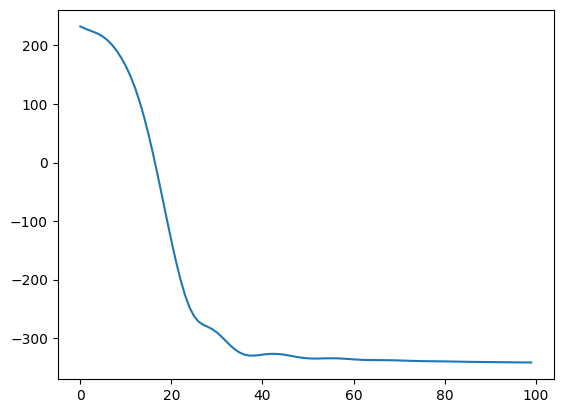

In [450]:
plt.plot(losses)

In [451]:
N,DIM = X_train.shape

X_reps = jnp.tile(jnp.expand_dims(X_train,0), (M,1,1))
X_reps_test = jnp.tile(jnp.expand_dims(X_test,0), (M,1,1))
P_projs = jax.random.normal(jax.random.PRNGKey(proj_seed), (M,DIM, proj_dim))/jnp.sqrt(proj_dim)   

X_projs = jax.vmap(lambda A,B: (A @ B).squeeze(), in_axes=(0, 0))(X_reps, P_projs)
X_projs_test = jax.vmap(lambda A,B: (A @ B).squeeze(), in_axes=(0, 0))(X_reps_test, P_projs)

In [452]:
X_projs.shape, X_projs_test.shape

((1, 456, 13), (1, 50, 13))

In [453]:
# Function to make predictions with the optimized GPs
def predict_fused_gp_with_projs(X_train, y_train, X_test, length_scales, variances, noises, weights):
    def gp_predict(X_train,X_test,length_scale, variance, noise):
        K = kernel_matrix(X_train, X_train, length_scale, variance, noise)
        K_s = kernel_matrix(X_test, X_train, length_scale, variance, noise, include_noise=False)
        K_ss = kernel_matrix(X_test, X_test, length_scale, variance, noise)
        
        K_chol = cho_factor(K, lower=True)[0]
        
        alpha = cho_solve((K_chol, True), y_train)
        v = cho_solve((K_chol, True), K_s.T)
        
        mu_s = K_s @ alpha
        cov_s = K_ss - K_s @ v
        
        return mu_s, jnp.diag(cov_s)
    
    mus, covs = vmap(gp_predict)(X_train,X_test,length_scales, variances, noises)  # we also vmap training and test datasets
    
    weighted_vars_inv = weights[:, None] / covs
    fused_vars = 1 / jnp.sum(weighted_vars_inv, axis=0)
    fused_means = fused_vars * jnp.sum(weighted_vars_inv * mus, axis=0)
    
    return fused_means, fused_vars

In [454]:
# Make predictions
mu_tst, var_tst = predict_fused_gp_with_projs(X_projs, y_train, X_projs_test, length_scales, variances, noises, weights)
mu_tr, var_tr = predict_fused_gp_with_projs(X_projs, y_train, X_projs, length_scales, variances, noises, weights)

print("NLPD Train: ", compute_neg_log_like(mus=mu_tr,stds=jnp.sqrt(var_tr),y_test=y_train))
print("NLPD Test: ",  compute_neg_log_like(mus=mu_tst,stds=jnp.sqrt(var_tst),y_test=y_test))

print("RMSE Train: ", jnp.sqrt( jnp.mean( (mu_tr.squeeze() - y_train.squeeze())**2 ) ))
print("RMSE Test: ", jnp.sqrt( jnp.mean( (mu_tst.squeeze() - y_test.squeeze())**2 ) ))


print("--------  Below, using initial parameter values -------")
# Make predictions
mu_tst, var_tst = predict_fused_gp_with_projs(X_projs, y_train, X_projs_test, 
                             transform(init_params[:M * proj_dim].reshape(M,proj_dim)), 
                             transform(init_params[M * proj_dim : M * (proj_dim + 1)].reshape((M,))), 
                             transform(init_params[M * (proj_dim + 1):M * (proj_dim + 2)].reshape((M,))), 
                             transform(init_params[M * (proj_dim + 2):].reshape((M,))),
                             )
mu_tr, var_tr = predict_fused_gp_with_projs(X_projs, y_train, X_projs, 
                             transform(init_params[:M * proj_dim].reshape(M,proj_dim)), 
                             transform(init_params[M * proj_dim : M * (proj_dim + 1)].reshape((M,))), 
                             transform(init_params[M * (proj_dim + 1):M * (proj_dim + 2)].reshape((M,))), 
                             transform(init_params[M * (proj_dim + 2):].reshape((M,))),
                             )

print("NLPD Train: ", compute_neg_log_like(mus=mu_tr,stds=jnp.sqrt(var_tr),y_test=y_train))
print("NLPD Test: ",  compute_neg_log_like(mus=mu_tst,stds=jnp.sqrt(var_tst),y_test=y_test))
print("RMSE Train: ", jnp.sqrt( jnp.mean( (mu_tr.squeeze() - y_train.squeeze())**2 ) ))
print("RMSE Test: ", jnp.sqrt( jnp.mean( (mu_tst.squeeze() - y_test.squeeze())**2 ) ))

NLPD Train:  [-0.46411303]
NLPD Test:  [0.10110296]
RMSE Train:  0.11789751340238046
RMSE Test:  0.3537610469693852
--------  Below, using initial parameter values -------
NLPD Train:  [0.45536206]
NLPD Test:  [1.34367729]
RMSE Train:  0.16749497751522419
RMSE Test:  0.8957889661826065


# With Pre-Projection Length scales

In [457]:
# LOO-CV objective function (negative log-score for minimization)
def loo_cv_objective(params, X, y, M,proj_dim, dim, normalize_weights=False, proj_seed = 42):

    N,DIM = X.shape

    length_scales_raw = lax.dynamic_slice(params, (0,), (dim,)).reshape((dim))
    variances_raw = lax.dynamic_slice(params, (dim,), (M,))
    noises_raw = lax.dynamic_slice(params, (M + dim,), (M,))
    weights_raw = lax.dynamic_slice(params, (M * 2 + dim,), (M,))
  
    length_scales, variances, noises = transform(length_scales_raw), transform(variances_raw), transform(noises_raw)
    weights = transform(weights_raw)

    X_reps = jnp.tile(jnp.expand_dims(X,0), (M,1,1))
    P_projs = jax.random.normal(jax.random.PRNGKey(proj_seed), (M,DIM, proj_dim))/jnp.sqrt(proj_dim)   

    X_projs = jax.vmap(lambda A,B: (A @ B).squeeze(), in_axes=(0, 0))(X_reps, P_projs/ length_scales[None, :, None])
    assert (length_scales[None, :, None] * P_projs).shape == P_projs.shape
    assert X_projs.shape == (M,N,proj_dim)

    
    if normalize_weights:
        weights = weights / jnp.sum(weights)
    
    def gp_loops(X,length_scale, variance, noise):
        K = kernel_matrix(X, X, length_scale, variance, noise)
        K_chol = cho_factor(K, lower=True)[0]
        alpha, diag_inv_K = compute_alpha_and_diag_inv_K(K_chol, y)
        
        loo_means = y - alpha / diag_inv_K
        loo_vars = 1 / diag_inv_K
        
        return loo_means, loo_vars
    
    loo_means, loo_vars = vmap(gp_loops)(X_projs, jnp.ones_like(variances), variances, noises)
    
    # Fuse the means and variances using the product rule with weights
    weighted_vars_inv = weights[:, None] / loo_vars
    fused_vars = 1 / jnp.sum(weighted_vars_inv, axis=0)
    fused_means = fused_vars * jnp.sum(weighted_vars_inv * loo_means, axis=0)

    # print(fused_means.shape, fused_vars.shape)
    
    # LOO predictive log-probability
    loo_cv_log_score = -0.5 * jnp.sum(jnp.log(fused_vars.squeeze()) + (y.squeeze() - fused_means.squeeze())**2 / fused_vars.squeeze())
    
    return -loo_cv_log_score  # Negative for minimization

# JIT compile the objective function for faster optimization
loo_cv_objective_with_projs_jit = jit(loo_cv_objective, static_argnames=['M','proj_dim',"dim","normalize_weights"])


In [458]:
M=1
proj_dim = X_train.shape[1]
init_params = jnp.concatenate(
    (
        0.1*jnp.ones((X_train.shape[1],)),      # lengthscales
        1.0*jnp.ones((M,)),                     # variances
        0.2*jnp.ones((M,)),                     # noises
        jnp.ones((M,)),                         # weights
        ),                   
)
init_params = inv_transform(init_params)
 
loo_cv_objective_with_projs_jit(init_params,X_train,y_train,M,proj_dim,X_train.shape[1], False)

Array(233.06916657, dtype=float64)

In [459]:
# Define the optimizer
optimizer = optax.adam(learning_rate=0.1)
opt_state = optimizer.init(init_params)

# Define the update step
@partial(jax.jit, static_argnames=['M', 'proj_dim', 'dim', 'normalize_weights'])
def update(params, opt_state, X, y, M, proj_dim, dim, normalize_weights,proj_seed):
    loss, grads = value_and_grad(loo_cv_objective_with_projs_jit)(params, X, y, M, proj_dim,dim,normalize_weights,proj_seed)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return loss, params, opt_state

# Training loop
params = init_params
num_steps = 250
normalize_weights = False  # Set this flag to True if weights should sum to 1
proj_seed = 2
dim = X_train.shape[1]
losses = []

for step in tqdm.tqdm(range(num_steps)):
    loss, params, opt_state = update(params, opt_state, X_train, y_train, M, proj_dim,dim,normalize_weights,proj_seed)
    losses.append(loss)
    if step % 100 == 0 or step == num_steps-1:
        print(f"Step {step}, Loss: {loss}")

# Get the optimized parameters
optimized_params = transform(params)  # Exclude weights from exponentiation
length_scales = optimized_params[:dim]
variances = optimized_params[dim:dim+M]
noises = optimized_params[dim+M:dim+2*M]
weights = optimized_params[-M:]  # Get the weights as they are (log transformation has already been applied)
if normalize_weights:
    weights = weights / jnp.sum(weights)

print("Optimized Length Scales:", length_scales)
print("Optimized Variances:", variances)
print("Optimized Noises:", noises)
print("Optimized Weights:", weights)

Step 0, Loss: 232.46868895219814
Step 100, Loss: -364.46716221627554
Step 200, Loss: -367.1897511814093
Step 249, Loss: -367.87622684504606
Optimized Length Scales: [1.24731145 7.02237229 3.89691448 0.10000117 1.07493514 2.43553445
 1.86106268 0.6994196  1.19724519 0.62852037 3.23692313 4.36776422
 1.96378341]
Optimized Variances: [1.82085339]
Optimized Noises: [0.03829376]
Optimized Weights: [1.2362451]


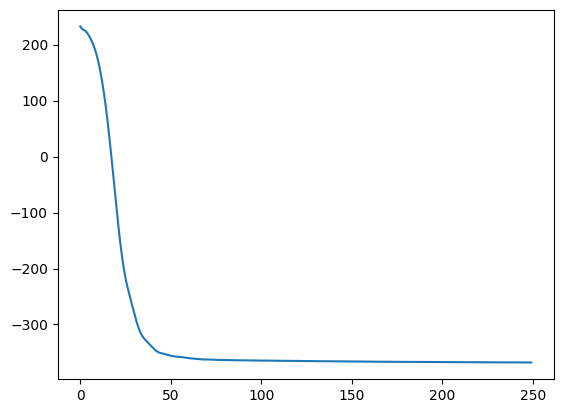

In [460]:
plt.plot(losses)

In [461]:
N,DIM = X_train.shape

X_reps = jnp.tile(jnp.expand_dims(X_train,0), (M,1,1))
X_reps_test = jnp.tile(jnp.expand_dims(X_test,0), (M,1,1))
P_projs = jax.random.normal(jax.random.PRNGKey(proj_seed), (M,DIM, proj_dim))/jnp.sqrt(proj_dim)   

X_projs = jax.vmap(lambda A,B: (A @ B).squeeze(), in_axes=(0, 0))(X_reps, P_projs/ length_scales[None, :, None])
X_projs_test = jax.vmap(lambda A,B: (A @ B).squeeze(), in_axes=(0, 0))(X_reps_test, P_projs/ length_scales[None, :, None])

In [462]:
# Make predictions
mu_tst, var_tst = predict_fused_gp_with_projs(X_projs, y_train, X_projs_test, jnp.ones_like(variances), variances, noises, weights)
mu_tr, var_tr = predict_fused_gp_with_projs(X_projs, y_train, X_projs, jnp.ones_like(variances), variances, noises, weights)

print("NLPD Train: ", compute_neg_log_like(mus=mu_tr,stds=jnp.sqrt(var_tr),y_test=y_train))
print("NLPD Test: ",  compute_neg_log_like(mus=mu_tst,stds=jnp.sqrt(var_tst),y_test=y_test))

print("RMSE Train: ", jnp.sqrt( jnp.mean( (mu_tr.squeeze() - y_train.squeeze())**2 ) ))
print("RMSE Test: ", jnp.sqrt( jnp.mean( (mu_tst.squeeze() - y_test.squeeze())**2 ) ))


print("--------  Below, using initial parameter values -------")
# Make predictions
mu_tst, var_tst = predict_fused_gp_with_projs(X_projs, y_train, X_projs_test, 
                             jnp.ones_like(variances),#jnp.ones((M, proj_dim)), 
                             transform(init_params[dim:dim+M].reshape((M,))), 
                             transform(init_params[dim+M:dim+2*M].reshape((M,))), 
                             transform(init_params[dim+2*M:].reshape((M,))),
                             )
mu_tr, var_tr = predict_fused_gp_with_projs(X_projs, y_train, X_projs, 
                             jnp.ones_like(variances),#jnp.ones((M, proj_dim)), 
                             transform(init_params[dim:dim+M].reshape((M,))), 
                             transform(init_params[dim+M:dim+2*M].reshape((M,))), 
                             transform(init_params[dim+2*M:].reshape((M,))),
                             )

print("NLPD Train: ", compute_neg_log_like(mus=mu_tr,stds=jnp.sqrt(var_tr),y_test=y_train))
print("NLPD Test: ",  compute_neg_log_like(mus=mu_tst,stds=jnp.sqrt(var_tst),y_test=y_test))
print("RMSE Train: ", jnp.sqrt( jnp.mean( (mu_tr.squeeze() - y_train.squeeze())**2 ) ))
print("RMSE Test: ", jnp.sqrt( jnp.mean( (mu_tst.squeeze() - y_test.squeeze())**2 ) ))

NLPD Train:  [-0.44541207]
NLPD Test:  [0.09072795]
RMSE Train:  0.12325527230464586
RMSE Test:  0.32291205735758893
--------  Below, using initial parameter values -------
NLPD Train:  [0.32149792]
NLPD Test:  [0.47628798]
RMSE Train:  0.21297715286065833
RMSE Test:  0.3409082451314772


# Organizando todo un poco


In [650]:
vmatmul = jax.vmap(lambda A,B: (A @ B).squeeze(), in_axes=(0, 0))

# Auxiliary functions
def transform(raw_param, fun = "softplus"):               # raw_param lives in (-inf,inf)
    if fun == "exp":
        param = jnp.exp(raw_param)                      # exponential
    elif fun == "softplus":
        param = jnp.log(1 + jnp.exp(raw_param))         # softplus
    else:
        raise ValueError("Transform function not implemented.")
    return param        # param lives in (0,inf)  

def inv_transform(cons_param, fun = "invsoftplus"):          # cons_param lives in (0,inf)
    if fun == "log":
        param = jnp.log(cons_param)                          #  log   
    elif fun == "invsoftplus":
        param = jnp.log(jnp.exp(cons_param) - 1)             # inverse softplus
    else:
        raise ValueError("Inverse transform function not implemented.")
    return param       # param lives in (-inf,inf) 


# RBF Kernel function with length_scale as a vector
def rbf_kernel(x1, x2, length_scale, variance):
    sqdist = jnp.sum(((x1 - x2) / length_scale) ** 2)
    return variance * jnp.exp(-0.5 * sqdist)

# Efficient kernel matrix computation using vmap
def kernel_matrix(X1, X2, length_scale, variance, noise, include_noise = True):
    pairwise_sqdists = jnp.sum(
        ((X1[:, None, :] - X2[None, :, :]) / jnp.broadcast_to(length_scale, X1[:, None, :].shape)) ** 2, 
        axis=-1)
    K = variance * jnp.exp(-0.5 * pairwise_sqdists)
    if include_noise:
        K += noise * jnp.eye(X1.shape[0])
    return K

# Compute alpha and diagonal elements of the inverse of K using Cholesky
def compute_alpha_and_diag_inv_K(K_chol, y):
    alpha = cho_solve((K_chol, True), y)
    
    compute_diag = jax.vmap(lambda A, b, i: cho_solve((A, True), b)[i], in_axes=(None, 0, 0))
    diag_inv_K = compute_diag(K_chol, jnp.eye(K_chol.shape[0]), jnp.arange(K_chol.shape[0])) 
    
    return alpha, diag_inv_K


# Function to make predictions with the optimized GPs
def predict_fused_gp(X_train, y_train, X_test, length_scales, variances, noises, weights):
    def gp_predict(length_scale, variance, noise):
        K = kernel_matrix(X_train, X_train, length_scale, variance, noise)
        K_s = kernel_matrix(X_test, X_train, length_scale, variance, noise, include_noise=False)
        K_ss = kernel_matrix(X_test, X_test, length_scale, variance, noise)
        
        K_chol = cho_factor(K, lower=True)[0]
        
        alpha = cho_solve((K_chol, True), y_train)
        v = cho_solve((K_chol, True), K_s.T)
        
        mu_s = K_s @ alpha
        cov_s = K_ss - K_s @ v
        
        return mu_s, jnp.diag(cov_s)
    
    mus, covs = vmap(gp_predict)(length_scales, variances, noises) 
    
    weighted_vars_inv = weights[:, None] / covs
    fused_vars = 1 / jnp.sum(weighted_vars_inv, axis=0)
    fused_means = fused_vars * jnp.sum(weighted_vars_inv * mus, axis=0)
    
    return fused_means, fused_vars, mus, covs


# Function to make predictions with the optimized GPs and projections
def predict_fused_gp_with_projs(X_train, y_train, X_test, length_scales, variances, noises, weights):
    def gp_predict(X_train,X_test,length_scale, variance, noise):
        K = kernel_matrix(X_train, X_train, length_scale, variance, noise)
        K_s = kernel_matrix(X_test, X_train, length_scale, variance, noise, include_noise=False)
        K_ss = kernel_matrix(X_test, X_test, length_scale, variance, noise)
        
        K_chol = cho_factor(K, lower=True)[0]
        
        alpha = cho_solve((K_chol, True), y_train)
        v = cho_solve((K_chol, True), K_s.T)
        
        mu_s = K_s @ alpha
        cov_s = K_ss - K_s @ v
        
        return mu_s, jnp.diag(cov_s)
    
    mus, covs = vmap(gp_predict)(X_train,X_test,length_scales, variances, noises)  # we also vmap training and test datasets
    
    weighted_vars_inv = weights[:, None] / covs
    fused_vars = 1 / jnp.sum(weighted_vars_inv, axis=0)
    fused_means = fused_vars * jnp.sum(weighted_vars_inv * mus, axis=0)
    
    return fused_means, fused_vars


In [598]:
# Loss functions 

# ======================================================= #
# ============= (1) WITHOUT projections  ================ #
# ======================================================= #
def loo_cv_objective_1(params, X, y, M,dim, normalize_weights=False):
    
    length_scales_raw = lax.dynamic_slice(params, (0,), (M * dim,)).reshape((M,dim))
    variances_raw = lax.dynamic_slice(params, (M * dim,), (M,))
    noises_raw = lax.dynamic_slice(params, (M * (dim + 1),), (M,))
    weights_raw = lax.dynamic_slice(params, (M * (dim + 2),), (M,))
 
    length_scales, variances, noises = transform(length_scales_raw), transform(variances_raw), transform(noises_raw)
    weights = transform(weights_raw)
    
    if normalize_weights:
        weights = weights / jnp.sum(weights)
    
    def gp_loops(length_scale, variance, noise):
        K = kernel_matrix(X, X, length_scale, variance, noise)
        K_chol = cho_factor(K, lower=True)[0]
        alpha, diag_inv_K = compute_alpha_and_diag_inv_K(K_chol, y)  # MAKE SURE y has one dimension => squeeze cabronazo!
        
        loo_means = y - alpha / diag_inv_K
        loo_vars = 1 / diag_inv_K
        
        return loo_means, loo_vars
    
    loo_means, loo_vars = vmap(gp_loops)(length_scales, variances, noises)
    
    # Fuse the means and variances using the product rule with weights
    weighted_vars_inv = weights[:, None] / loo_vars
    fused_vars = 1 / jnp.sum(weighted_vars_inv, axis=0)
    fused_means = fused_vars * jnp.sum(weighted_vars_inv * loo_means, axis=0)
    
    # LOO predictive log-probability
    loo_cv_log_score = -0.5 * jnp.sum(jnp.log(fused_vars.squeeze()) + \
                                      (y.squeeze() - fused_means.squeeze())**2 / fused_vars.squeeze())
    
    return -loo_cv_log_score  # Negative for minimization

# ======================================================= #
# ================ (2) WITH projections  ================ #
# ======================================================= #
def loo_cv_objective_2(params, X, y, M,proj_dim, normalize_weights=False, proj_seed = 42):
    N,DIM = X.shape

    length_scales_raw = lax.dynamic_slice(params, (0,), (M * proj_dim,)).reshape((M,proj_dim))
    variances_raw = lax.dynamic_slice(params, (M * proj_dim,), (M,))
    noises_raw = lax.dynamic_slice(params, (M * (proj_dim + 1),), (M,))
    weights_raw = lax.dynamic_slice(params, (M * (proj_dim + 2),), (M,))
  
    length_scales, variances, noises = transform(length_scales_raw), transform(variances_raw), transform(noises_raw)
    weights = transform(weights_raw)
    if normalize_weights:
        weights = weights / jnp.sum(weights)

    X_reps = jnp.tile(jnp.expand_dims(X,0), (M,1,1))
    P_projs = jax.random.normal(jax.random.PRNGKey(proj_seed), (M,DIM, proj_dim))/jnp.sqrt(proj_dim)   
    X_projs = vmatmul(X_reps, P_projs)
    assert X_projs.shape == (M,N,proj_dim)  
    
    def gp_loops(X,length_scale, variance, noise):
        K = kernel_matrix(X, X, length_scale, variance, noise)
        K_chol = cho_factor(K, lower=True)[0]
        alpha, diag_inv_K = compute_alpha_and_diag_inv_K(K_chol, y)
        
        loo_means = y - alpha / diag_inv_K
        loo_vars = 1 / diag_inv_K
        
        return loo_means, loo_vars
    
    loo_means, loo_vars = vmap(gp_loops)(X_projs,length_scales, variances, noises)  # We also map over training inputs
    
    # Fuse the means and variances using the product rule with weights
    weighted_vars_inv = weights[:, None] / loo_vars
    fused_vars = 1 / jnp.sum(weighted_vars_inv, axis=0)
    fused_means = fused_vars * jnp.sum(weighted_vars_inv * loo_means, axis=0)
    
    # LOO predictive log-probability
    loo_cv_log_score = -0.5 * jnp.sum(jnp.log(fused_vars.squeeze()) + \
                                      (y.squeeze() - fused_means.squeeze())**2 / fused_vars.squeeze())
    
    return -loo_cv_log_score  # Negative for minimization


# ============================================================ #
# ======== (3) WITH projections AND PRE-projections ========== #
# ============================================================ #
def loo_cv_objective_3(params, X, y, M,proj_dim, dim, normalize_weights=False, proj_seed = 42):
    N,_ = X.shape

    length_scales_raw = lax.dynamic_slice(params, (0,), (dim,)).reshape((dim))  # these are lengthscales for PRE-projection; experts have no lengthscales
    variances_raw = lax.dynamic_slice(params, (dim,), (M,))
    noises_raw = lax.dynamic_slice(params, (M + dim,), (M,))
    weights_raw = lax.dynamic_slice(params, (M * 2 + dim,), (M,))
  
    length_scales, variances, noises = transform(length_scales_raw), transform(variances_raw), transform(noises_raw)
    weights = transform(weights_raw)
    if normalize_weights:
        weights = weights / jnp.sum(weights)

    X_reps = jnp.tile(jnp.expand_dims(X,0), (M,1,1))
    P_projs = jax.random.normal(jax.random.PRNGKey(proj_seed), (M,dim, proj_dim))/jnp.sqrt(proj_dim)   

    X_projs = vmatmul(X_reps, P_projs/ length_scales[None, :, None])
    assert (length_scales[None, :, None] * P_projs).shape == P_projs.shape
    assert X_projs.shape == (M,N,proj_dim)

    
    def gp_loops(X,length_scale, variance, noise):
        K = kernel_matrix(X, X, length_scale, variance, noise)
        K_chol = cho_factor(K, lower=True)[0]
        alpha, diag_inv_K = compute_alpha_and_diag_inv_K(K_chol, y)
        
        loo_means = y - alpha / diag_inv_K
        loo_vars = 1 / diag_inv_K
        
        return loo_means, loo_vars
    
    loo_means, loo_vars = vmap(gp_loops)(X_projs, jnp.ones_like(variances), variances, noises) # We set experts' lengthscales to 1
    
    # Fuse the means and variances using the product rule with weights
    weighted_vars_inv = weights[:, None] / loo_vars
    fused_vars = 1 / jnp.sum(weighted_vars_inv, axis=0)
    fused_means = fused_vars * jnp.sum(weighted_vars_inv * loo_means, axis=0)
    
    # LOO predictive log-probability
    loo_cv_log_score = -0.5 * jnp.sum(jnp.log(fused_vars.squeeze()) + \
                                      (y.squeeze() - fused_means.squeeze())**2 / fused_vars.squeeze())
    
    return -loo_cv_log_score  # Negative for minimization




# JIT compile the objective function for faster optimization
loo_cv_objective_1_jit = jit(loo_cv_objective_1, static_argnames=['M','dim',"normalize_weights"])
loo_cv_objective_2_jit = jit(loo_cv_objective_2, static_argnames=['M','proj_dim',"normalize_weights"])
loo_cv_objective_3_jit = jit(loo_cv_objective_3, static_argnames=['M','proj_dim',"dim","normalize_weights"])


In [599]:
def optimize_objective(obj_fun_jit,init_params,static_argnames,lr = 0.1, num_steps=100, **kwargs):
    # **kwargs should contain all parameters needed by the objective that are not being optimized, namely, contained in params

    # Define the optimizer
    optimizer = optax.adam(learning_rate=lr)
    opt_state = optimizer.init(init_params)

    # Define the update step
    @partial(jax.jit, static_argnames=static_argnames)
    def update(params, opt_state,**kwargs):
        loss, grads = value_and_grad(obj_fun_jit)(params, **kwargs)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return loss, params, opt_state

    # Training loop
    params = init_params
    losses = []
    for step in tqdm.tqdm(range(num_steps)):
        loss, params, opt_state = update(params, opt_state, **kwargs)
        losses.append(loss)
        if step % 100 == 0 or step == num_steps-1:
            print(f"Step {step}, Loss: {loss}")

    # Get the optimized parameters
    return params, losses

In [600]:
dataset_name = "housing"
full_dataset = Dataset(dataset_name)
N,DIM = full_dataset.x.shape

split = 0
X_train,y_train,X_test,y_test,_ = load_data(dataset_name,split)

housing dataset, N=506, d=13


## Objective 1: without projections

In [666]:
M = 20  # Number of GPs

# Initial parameters: length_scale, variance, noise, weights (they have to be positive!)
init_params = jnp.concatenate(
(
    # 0.1*jnp.ones((D,)), 0.5*jnp.ones((D,)), 1*jnp.ones((D,)),
    0.5 - 0.5*jax.random.uniform(jax.random.PRNGKey(42), (M*D,)) ,
    # 0.1*jnp.ones((M*D,)),
    jnp.ones((M,)),
    0.2*jnp.ones((M,)),
    jnp.ones((M,))
    )
)
init_params = inv_transform(init_params)
static_argnames = ['M', 'dim', 'normalize_weights']
other_params = {'X': X_train, 
                'y': y_train, 
                'M': M, 
                'dim': DIM, 
                'normalize_weights': True,
                }

optimized_params,losses = optimize_objective(loo_cv_objective_1_jit,init_params,static_argnames,**other_params)

# get the optimized parameters
optimized_params = transform(optimized_params)

length_scales = optimized_params[:M * DIM].reshape((M, DIM))
variances = optimized_params[M * DIM:M * (DIM + 1)]
noises = optimized_params[M * (DIM + 1):M * (DIM + 2)]
weights = optimized_params[-M:]  # Get the weights as they are 
if normalize_weights:
    weights = weights / jnp.sum(weights)

print("Optimized Length Scales:", length_scales)
print("Optimized Variances:", variances)
print("Optimized Noises:", noises)
print("Optimized Weights:", weights)

  1%|          | 1/100 [00:02<04:00,  2.43s/it]

Step 0, Loss: 214.26731659698086


100%|██████████| 100/100 [01:41<00:00,  1.01s/it]

Step 99, Loss: -431.94295816854617
Optimized Length Scales: [[3.11502672e+00 6.26956085e-01 2.57192001e+00 5.90317856e-02
  6.84024716e+00 1.58019846e+00 6.70995528e+00 2.06051961e-01
  1.41810370e+00 1.01022572e+01 3.96671995e+00 1.59312859e+00
  5.15685851e+00]
 [3.62089497e-03 1.01464033e-01 6.98330965e-01 2.39135926e-01
  8.42793554e-02 1.02286946e-01 2.04607512e-01 1.08967256e+00
  4.50247354e-02 3.84540479e-02 5.83532955e-03 3.08139849e-01
  1.76628275e+00]
 [8.06627764e+00 3.77201662e+00 8.51663091e-01 1.99034364e-01
  1.22266247e-01 4.09724173e+00 3.60602401e+00 4.45248797e-01
  1.12682620e+00 3.85248491e-01 5.11009631e+00 2.41513448e+00
  6.73267766e+00]
 [3.31564050e+00 5.62057393e-02 6.72856386e-02 2.56200892e-01
  3.02711815e+00 2.18625625e+00 1.31564454e+00 1.29615791e-01
  1.59752636e-01 7.45904357e-02 4.15907717e-03 2.78033770e+00
  9.87008031e-01]
 [1.64661873e+00 5.87170522e-01 3.43549092e+00 9.66123999e-02
  8.01147698e-02 1.92165215e+00 1.94199818e-01 3.01987039e+00


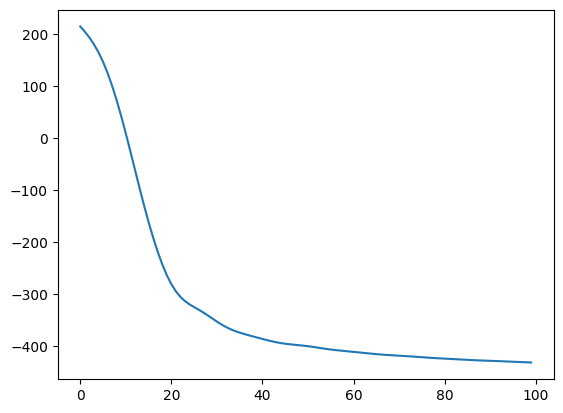

In [667]:
plt.plot(losses)

In [668]:
init_length_scales = transform(init_params[:M * DIM].reshape(M,DIM))
init_variances =  transform(init_params[M * DIM : M * (DIM + 1)].reshape((M,)))
init_noises =  transform(init_params[M * (DIM + 1):M * (DIM + 2)].reshape((M,)))
init_weights = transform(init_params[M * (DIM + 2):].reshape((M,)))
if other_params["normalize_weights"]:
    init_weights = init_weights/jnp.sum(init_weights)

In [669]:
# Make predictions
mu_tst, var_tst,_,_ = predict_fused_gp(X_train, y_train, X_test, length_scales, variances, noises, weights)
mu_tr, var_tr,_,_ = predict_fused_gp(X_train, y_train, X_train, length_scales, variances, noises, weights)

print("NLPD Train: ", compute_neg_log_like(mus=mu_tr,stds=jnp.sqrt(var_tr),y_test=y_train))
print("NLPD Test: ",  compute_neg_log_like(mus=mu_tst,stds=jnp.sqrt(var_tst),y_test=y_test))

print("RMSE Train: ", jnp.sqrt( jnp.mean( (mu_tr.squeeze() - y_train.squeeze())**2 ) ))
print("RMSE Test: ", jnp.sqrt( jnp.mean( (mu_tst.squeeze() - y_test.squeeze())**2 ) ))


print("--------  Below, using initial parameter values -------")
# Make predictions
mu_tst, var_tst,_,_ = predict_fused_gp(X_train, y_train, X_test, 
                             init_length_scales,
                             init_variances,
                             init_noises,
                             init_weights,
                             )
mu_tr, var_tr,_,_ = predict_fused_gp(X_train, y_train, X_train, 
                             init_length_scales,
                             init_variances,
                             init_noises,
                             init_weights,
                             )

print("NLPD Train: ", compute_neg_log_like(mus=mu_tr,stds=jnp.sqrt(var_tr),y_test=y_train))
print("NLPD Test: ",  compute_neg_log_like(mus=mu_tst,stds=jnp.sqrt(var_tst),y_test=y_test))
print("RMSE Train: ", jnp.sqrt( jnp.mean( (mu_tr.squeeze() - y_train.squeeze())**2 ) ))
print("RMSE Test: ", jnp.sqrt( jnp.mean( (mu_tst.squeeze() - y_test.squeeze())**2 ) ))

NLPD Train:  [-1.07094565]
NLPD Test:  [-0.11291733]
RMSE Train:  0.04968908303259178
RMSE Test:  0.2522581803756413
--------  Below, using initial parameter values -------
NLPD Train:  [0.45202133]
NLPD Test:  [1.3105786]
RMSE Train:  0.16288426627506283
RMSE Test:  0.861893592502144


## Objective 2: With projections but without pre-projections

In [612]:
M=2
proj_dim = X_train.shape[1]
proj_seed = 2
init_params = jnp.concatenate(
    (
        0.1*jnp.ones((M * proj_dim,)),      # lengthscales
        1.0*jnp.ones((M,)),                 # variances
        0.2*jnp.ones((M,)),                 # noises
        jnp.ones((M,)),                     # weights
        ),                   
)
init_params = inv_transform(init_params)
other_params = {'X': X_train, 
                'y': y_train, 
                'M': M, 
                'proj_dim': proj_dim, 
                'normalize_weights': True,
                'proj_seed': proj_seed,
                }
static_argnames=['M', 'proj_dim', 'normalize_weights']

optimized_params,losses = optimize_objective(loo_cv_objective_2_jit,init_params,static_argnames,**other_params)

# Get the optimized parameters
optimized_params = transform(optimized_params)

length_scales = optimized_params[:M * proj_dim].reshape((M, proj_dim))
variances = optimized_params[M * proj_dim:M * (proj_dim + 1)]
noises = optimized_params[M * (proj_dim + 1):M * (proj_dim + 2)]
weights = optimized_params[-M:]  
if normalize_weights:
    weights = weights / jnp.sum(weights)

print("Optimized Length Scales:", length_scales)
print("Optimized Variances:", variances)
print("Optimized Noises:", noises)
print("Optimized Weights:", weights)

  1%|          | 1/100 [00:01<03:15,  1.98s/it]

Step 0, Loss: 232.59908206558495


100%|██████████| 100/100 [00:25<00:00,  3.98it/s]

Step 99, Loss: -383.8814720640657
Optimized Length Scales: [[3.19441972 2.45908342 2.55210551 2.80306188 2.59896391 1.30727212
  0.35381629 3.15216417 3.30424841 1.2258289  1.6660006  2.53205343
  2.90313252]
 [2.23010387 0.52309542 0.85143972 4.52046885 3.57217517 0.44289719
  4.29809989 5.66245716 4.70397655 1.37985412 3.01043918 2.57571795
  5.80471558]]
Optimized Variances: [1.12146807 2.30558283]
Optimized Noises: [0.06521735 0.00129317]
Optimized Weights: [0.7813585 0.2186415]


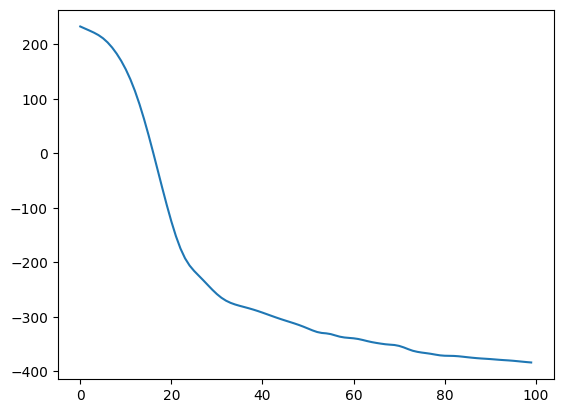

In [613]:
plt.plot(losses)

In [614]:
N,DIM = X_train.shape

X_reps = jnp.tile(jnp.expand_dims(X_train,0), (M,1,1))
X_reps_test = jnp.tile(jnp.expand_dims(X_test,0), (M,1,1))
P_projs = jax.random.normal(jax.random.PRNGKey(proj_seed), (M,DIM, proj_dim))/jnp.sqrt(proj_dim)   

X_projs = vmatmul(X_reps, P_projs)
X_projs_test = vmatmul(X_reps_test, P_projs)

In [615]:
init_length_scales = transform(init_params[:M * proj_dim].reshape(M,proj_dim)) 
init_variances  =  transform(init_params[M * proj_dim : M * (proj_dim + 1)].reshape((M,)))
init_noises = transform(init_params[M * (proj_dim + 1):M * (proj_dim + 2)].reshape((M,))) 
init_weights = transform(init_params[M * (proj_dim + 2):].reshape((M,)))
if other_params["normalize_weights"]:
    init_weights = init_weights/jnp.sum(init_weights)

In [616]:
# Make predictions
mu_tst, var_tst = predict_fused_gp_with_projs(X_projs, y_train, X_projs_test, length_scales, variances, noises, weights)
mu_tr, var_tr = predict_fused_gp_with_projs(X_projs, y_train, X_projs, length_scales, variances, noises, weights)

print("NLPD Train: ", compute_neg_log_like(mus=mu_tr,stds=jnp.sqrt(var_tr),y_test=y_train))
print("NLPD Test: ",  compute_neg_log_like(mus=mu_tst,stds=jnp.sqrt(var_tst),y_test=y_test))

print("RMSE Train: ", jnp.sqrt( jnp.mean( (mu_tr.squeeze() - y_train.squeeze())**2 ) ))
print("RMSE Test: ", jnp.sqrt( jnp.mean( (mu_tst.squeeze() - y_test.squeeze())**2 ) ))


print("--------  Below, using initial parameter values -------")
# Make predictions
mu_tst, var_tst = predict_fused_gp_with_projs(X_projs, y_train, X_projs_test, 
                             init_length_scales,
                             init_variances,
                             init_noises,
                             init_weights,
                             )
mu_tr, var_tr = predict_fused_gp_with_projs(X_projs, y_train, X_projs, 
                             init_length_scales,
                             init_variances,
                             init_noises,
                             init_weights,
                             )

print("NLPD Train: ", compute_neg_log_like(mus=mu_tr,stds=jnp.sqrt(var_tr),y_test=y_train))
print("NLPD Test: ",  compute_neg_log_like(mus=mu_tst,stds=jnp.sqrt(var_tst),y_test=y_test))
print("RMSE Train: ", jnp.sqrt( jnp.mean( (mu_tr.squeeze() - y_train.squeeze())**2 ) ))
print("RMSE Test: ", jnp.sqrt( jnp.mean( (mu_tst.squeeze() - y_test.squeeze())**2 ) ))

NLPD Train:  [-1.31934878]
NLPD Test:  [0.16276223]
RMSE Train:  0.03128687380277726
RMSE Test:  0.31884570979603244
--------  Below, using initial parameter values -------
NLPD Train:  [0.45536149]
NLPD Test:  [1.33884756]
RMSE Train:  0.16760463311857376
RMSE Test:  0.8905438288140636


## Objective 3: with projections and pre-projections

In [659]:
M=10
proj_dim = X_train.shape[1]
proj_seed = 2
init_params = jnp.concatenate(
    (
        0.1*jnp.ones((X_train.shape[1],)),      # lengthscales
        1.0*jnp.ones((M,)),                     # variances
        0.2*jnp.ones((M,)),                     # noises
        jnp.ones((M,)),                         # weights
        ),                   
)
init_params = inv_transform(init_params)

other_params = {'X': X_train, 
                'y': y_train, 
                'M': M, 
                'proj_dim': proj_dim, 
                'dim': DIM,
                'normalize_weights': True,
                'proj_seed': proj_seed,
                }
static_argnames=['M', 'proj_dim', 'dim', 'normalize_weights']

optimized_params,losses = optimize_objective(loo_cv_objective_3_jit,init_params,static_argnames,
                                             lr = 0.1, num_steps = 250,
                                             **other_params)

# Get the optimized parameters
optimized_params = transform(optimized_params)  
length_scales = optimized_params[:DIM]  # not the experts' lengthscales but pre-projection lengthscales!
variances = optimized_params[DIM:DIM+M]
noises = optimized_params[DIM+M:DIM+2*M]
weights = optimized_params[-M:]  
if normalize_weights:
    weights = weights / jnp.sum(weights)

print("Optimized Length Scales:", length_scales)
print("Optimized Variances:", variances)
print("Optimized Noises:", noises)
print("Optimized Weights:", weights)

  0%|          | 1/250 [00:02<09:19,  2.25s/it]

Step 0, Loss: 232.74912129777127


 40%|████      | 101/250 [00:50<01:15,  1.97it/s]

Step 100, Loss: -382.71591991346827


 80%|████████  | 201/250 [01:39<00:24,  2.04it/s]

Step 200, Loss: -385.96616627062474


100%|██████████| 250/250 [02:02<00:00,  2.04it/s]

Step 249, Loss: -386.4410280134898
Optimized Length Scales: [4.95861509 4.2276547  4.0700142  0.10000041 1.40607638 1.89557898
 3.91905883 0.56371393 1.89586469 1.89036711 4.8165331  2.78611724
 1.17439457]
Optimized Variances: [1.4805593  2.15445464 2.28772661 0.47096266 1.28603935 1.92466702
 2.07593118 1.63875967 2.84196256 1.86005449]
Optimized Noises: [0.04210601 0.05587733 0.00310941 0.07441252 0.15213897 0.16041084
 0.3467047  0.00640183 0.04388851 0.09833832]
Optimized Weights: [0.30229639 0.00378289 0.10461192 0.12225895 0.01550845 0.01325345
 0.00191459 0.03521016 0.39664303 0.00452016]


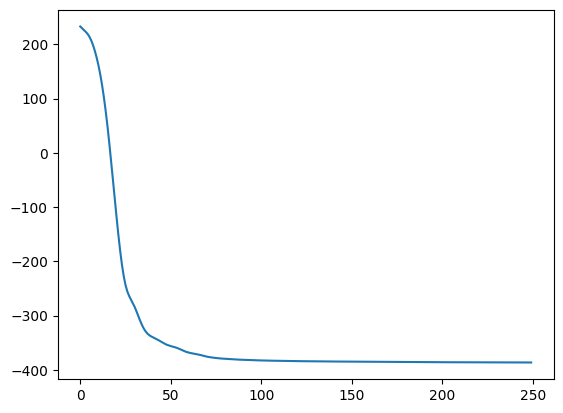

In [660]:
plt.plot(losses)

In [663]:
N,DIM = X_train.shape

X_reps = jnp.tile(jnp.expand_dims(X_train,0), (M,1,1))
X_reps_test = jnp.tile(jnp.expand_dims(X_test,0), (M,1,1))
P_projs = jax.random.normal(jax.random.PRNGKey(proj_seed), (M,DIM, proj_dim))/jnp.sqrt(proj_dim)   

X_projs = vmatmul(X_reps, P_projs/ length_scales[None, :, None])
X_projs_test = vmatmul(X_reps_test, P_projs/ length_scales[None, :, None])

In [664]:
init_length_scales = transform(init_params[:DIM].reshape((DIM,)))
init_variances = transform(init_params[DIM:DIM+M].reshape((M,)))
init_noises = transform(init_params[DIM+M:DIM+2*M].reshape((M,)))
init_weights = transform(init_params[DIM+2*M:].reshape((M,)))
if other_params["normalize_weights"]:
    init_weights = init_weights/jnp.sum(init_weights)

In [665]:
# Make predictions
mu_tst, var_tst = predict_fused_gp_with_projs(X_projs, y_train, X_projs_test, jnp.ones_like(variances), variances, noises, weights)
mu_tr, var_tr = predict_fused_gp_with_projs(X_projs, y_train, X_projs, jnp.ones_like(variances), variances, noises, weights)

print("NLPD Train: ", compute_neg_log_like(mus=mu_tr,stds=jnp.sqrt(var_tr),y_test=y_train))
print("NLPD Test: ",  compute_neg_log_like(mus=mu_tst,stds=jnp.sqrt(var_tst),y_test=y_test))

print("RMSE Train: ", jnp.sqrt( jnp.mean( (mu_tr.squeeze() - y_train.squeeze())**2 ) ))
print("RMSE Test: ", jnp.sqrt( jnp.mean( (mu_tst.squeeze() - y_test.squeeze())**2 ) ))


print("--------  Below, using initial parameter values -------")
X_projs = vmatmul(X_reps, P_projs/ init_length_scales[None, :, None])  # using initial length_scales
X_projs_test = vmatmul(X_reps_test, P_projs/ init_length_scales[None, :, None]) # using initial length_scales
# Make predictions
mu_tst, var_tst = predict_fused_gp_with_projs(X_projs, y_train, X_projs_test, 
                             jnp.ones_like(variances), 
                             init_variances, 
                             init_noises, 
                             init_weights,
                             )
mu_tr, var_tr = predict_fused_gp_with_projs(X_projs, y_train, X_projs, 
                             jnp.ones_like(variances),
                             init_variances, 
                             init_noises, 
                             init_weights,
                             )

print("NLPD Train: ", compute_neg_log_like(mus=mu_tr,stds=jnp.sqrt(var_tr),y_test=y_train))
print("NLPD Test: ",  compute_neg_log_like(mus=mu_tst,stds=jnp.sqrt(var_tst),y_test=y_test))
print("RMSE Train: ", jnp.sqrt( jnp.mean( (mu_tr.squeeze() - y_train.squeeze())**2 ) ))
print("RMSE Test: ", jnp.sqrt( jnp.mean( (mu_tst.squeeze() - y_test.squeeze())**2 ) ))

NLPD Train:  [-0.73347703]
NLPD Test:  [0.03081633]
RMSE Train:  0.08113234355325465
RMSE Test:  0.27625654766393554
--------  Below, using initial parameter values -------
NLPD Train:  [0.45542594]
NLPD Test:  [1.33812329]
RMSE Train:  0.16761582498532573
RMSE Test:  0.8891845851991627
